In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= "darkgrid", color_codes = True)

In [2]:
loan_dataset= pd.read_csv("Loan approval.csv")
loan_dataset.head(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
loan_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
loan_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
ApplicantIncome,614.0,5403.459283,6109.041673,150.0,2877.5,3812.5,5795.00,81000.0
CoapplicantIncome,614.0,1621.245798,2926.248369,0.0,0.0,1188.5,2297.25,41667.0
LoanAmount,592.0,146.412162,85.587325,9.0,100.0,128.0,168.00,700.0
Loan_Amount_Term,600.0,342.000000,65.120410,12.0,360.0,360.0,360.00,480.0
Credit_History,564.0,0.842199,0.364878,0.0,1.0,1.0,1.00,1.0


In [5]:
print(f'Shape of Loan Dataset before drop duplicated Row is: {loan_dataset.shape}')
loan_dataset = loan_dataset.drop_duplicates()
print(f'Shape of Loan Dataset After Drop Duplicated Row is: {loan_dataset.shape}')

Shape of Loan Dataset before drop duplicated Row is: (614, 13)
Shape of Loan Dataset After Drop Duplicated Row is: (614, 13)


# No duplicated samples


In [6]:
# Drop Unecessary Variables 
loan_dataset = loan_dataset.drop("Loan_ID", axis=1)

In [7]:

categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed','Property_Area','Credit_History']
continuous_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [8]:
# Splitting Data into Train, Validation, and Test Sets
X = loan_dataset.drop(columns='Loan_Status')
Y = loan_dataset['Loan_Status']

# Splitting into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2,stratify=Y, shuffle=True, random_state = 40)

# Splitting Validation Set into Validation and Test Sets
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, shuffle=True, random_state = 40)

In [9]:
class Plotter:
    
    def __init__(self, X, y):
        self.x_train = X
        self.y_train = y
        self.fig, self.axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))  
    
    def Plot_Box(self, row, col, x):
        ax = self.axes[row, col]  
        sns.boxplot(data=self.x_train, x=x, y=self.y_train, ax=ax)
        ax.set_title(f"{x.capitalize()} vs. Loan_Status ")

    def Show_Plots(self):
        plt.tight_layout()
        plt.show()

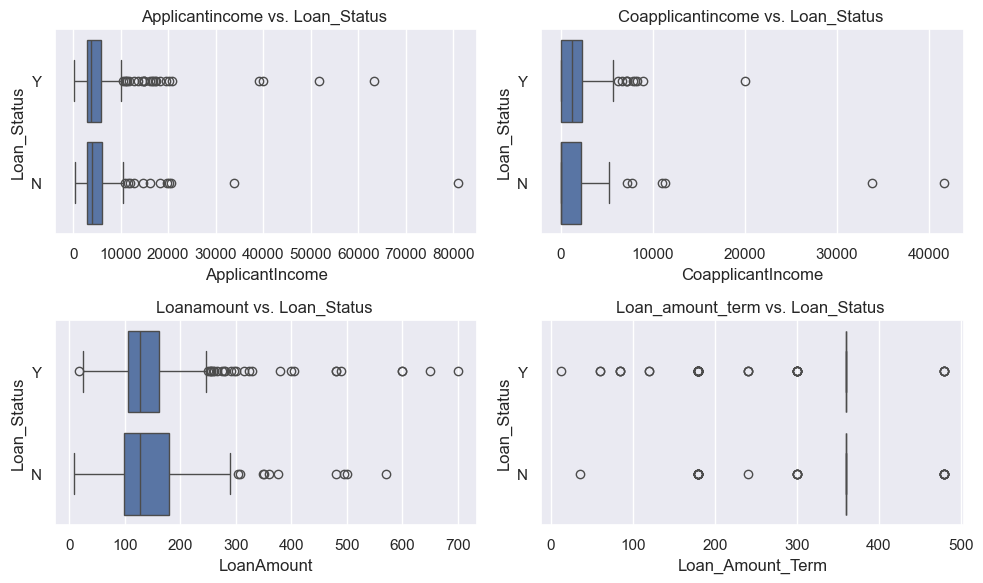

In [10]:
plot_continuous_features = Plotter(X_train, y_train)

# Plot the box plots
for i, col in enumerate(continuous_features):
    plot_continuous_features.Plot_Box(i // 2, i % 2, x=col)

plot_continuous_features.Show_Plots()

In [11]:
# Create an DataFrame for Analysis Categorical Features 
result_df = pd.DataFrame(columns=['Features', 'Category', 'Count'])

for col in categorical_features:
    # Get the value counts for the column
    value_counts = loan_dataset[col].value_counts().reset_index()
    value_counts.columns = ['Category', 'Count']
    value_counts['Features'] = col
    result_df = pd.concat([result_df, value_counts], ignore_index=True)
    
# Display the result
grouped_df = result_df.groupby('Features').agg({'Category': list, 'Count': list})
grouped_df

,Category,Count
Features,,
Credit_History,"[1.0, 0.0]","[475, 89]"
Dependents,"[0, 1, 2, 3+]","[345, 102, 101, 51]"
Education,"[Graduate, Not Graduate]","[480, 134]"
Gender,"[Male, Female]","[489, 112]"
Married,"[Yes, No]","[398, 213]"
Property_Area,"[Semiurban, Urban, Rural]","[233, 202, 179]"
Self_Employed,"[No, Yes]","[500, 82]"


In [12]:
# Missing Value Analysis 
def calculate_missing_values(X_train, X_val, X_test):
    Miss_Train = X_train.isna().sum()
    Miss_Val = X_val.isna().sum()
    Miss_test = X_test.isna().sum()
    
    # Convert the series to dataframes
    output_train = pd.DataFrame(Miss_Train, columns=['Missing Values X_train'])
    output_val = pd.DataFrame(Miss_Val, columns=['Missing Values X_val'])
    output_test = pd.DataFrame(Miss_test, columns=['Missing Values X_test'])


    # Concatenate the dataframes output_train and output_val
    output = pd.concat([output_train, output_val,output_test], axis=1, join='inner')

    return output

output = calculate_missing_values(X_train, X_val, X_test)

# Define a function to apply the desired styling
def color_cell(value):
    if value >=20 :
        return 'background-color:#2e9ee8'
    elif value >=10 and value <20 :
        return 'background-color:#7ac1f0'
    elif value >=1 and value <10 :
        return 'background-color:#bdddf2'
    return ''

# Apply the styling to the DataFrame
styled_df = output.style.map(color_cell)

styled_df

,Missing Values X_train,Missing Values X_val,Missing Values X_test
Gender,6,4,3
Married,2,0,1
Dependents,11,2,2
Education,0,0,0
Self_Employed,29,2,1
ApplicantIncome,0,0,0
CoapplicantIncome,0,0,0
LoanAmount,21,1,0
Loan_Amount_Term,12,0,2
Credit_History,42,4,4


In [13]:
# Finding Rows with 50% or More Null Values in each sets

def find_rows_with_high_null_values(df):
    threshold = 0.5
    # Getting DataFrame Name
    df_name = [name for name in globals() if globals()[name] is df][0]
    null_threshold = int(threshold * len(df.columns))
    null_rows = df[df.apply(lambda x: x.isnull().sum(), axis=1) >= null_threshold]
    num_null_rows = len(null_rows)
    print(f"The number of rows consisting of more than 50% missing values in {df_name} is: {num_null_rows}")

# Example usage:
find_rows_with_high_null_values(X_train)
find_rows_with_high_null_values(X_val)
find_rows_with_high_null_values(X_test)

The number of rows consisting of more than 50% missing values in X_train is: 0
The number of rows consisting of more than 50% missing values in X_val is: 0
The number of rows consisting of more than 50% missing values in X_test is: 0


In [14]:
# calculate mean columns

def calculate_mean(df, column):
    mean = df[column].mean().round()
    return mean

for col in ["LoanAmount","Loan_Amount_Term"]:
    print(f'Mean {col} in Trainset is: {calculate_mean(X_train, col)}')
    print(f'Mean {col} in Valset is: {calculate_mean(X_val, col)}')
    print(f'Mean {col} in Testset is: {calculate_mean(X_test, col)}')

Mean LoanAmount in Trainset is: 148.0
Mean LoanAmount in Valset is: 140.0
Mean LoanAmount in Testset is: 140.0
Mean Loan_Amount_Term in Trainset is: 341.0
Mean Loan_Amount_Term in Valset is: 346.0
Mean Loan_Amount_Term in Testset is: 346.0


In [15]:
Nominal_fetaures = ['Gender', 'Married','Education', 'Self_Employed', 'Property_Area']

In [16]:
# Encoding Categorical Features
def encode_categorical_features(df, cols):
    
    for col in cols:
        dummies = pd.get_dummies(df[col], dtype=int, prefix=col)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(labels=col, axis=1)
    return df

# Encode the categorical features in the training and test sets
X_train = encode_categorical_features(X_train, Nominal_fetaures)
X_val = encode_categorical_features(X_val, Nominal_fetaures )
X_test = encode_categorical_features(X_test, Nominal_fetaures )

In [17]:
encoder = {'0': 1/4, '1': 2/4, '2': 3/4, '3+': 4/4}
for df in [X_train, X_val, X_test]:
    df["Dependents"] = df['Dependents'].map(encoder)

In [21]:
X_train.head(5)

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
101,0.25,4843,3806.0,151.0,360.0,1.0,0,1,1,0,1,0,1,0,0,1,0
116,0.25,3167,2283.0,154.0,360.0,1.0,1,0,0,1,1,0,1,0,0,1,0
191,0.25,12000,0.0,164.0,360.0,1.0,0,1,1,0,1,0,1,0,0,1,0
237,0.25,3463,0.0,122.0,360.0,NaN,1,0,1,0,1,0,0,1,0,0,1
222,0.25,2971,2791.0,144.0,360.0,1.0,0,1,1,0,1,0,1,0,0,1,0
